### Imports and Global Settings

In [107]:
import torch
from hw_library import *

from copy import deepcopy

import matplotlib.pyplot as plt 
%matplotlib inline

# This one is an awesome built-in IPython extension.
# It automatically reloads your modules whenever
# you execute code, so that you don't have to
# re-run this cell each time you change your library code.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# Maybe add some global variables here for your config
hparams = {
    "train_path" : "/Users/hcagri/Documents/METU-Master/Term II/CENG 796/Homeworks/Hw1/Data/DatasetA_train.npy",
    "test_path" : "/Users/hcagri/Documents/METU-Master/Term II/CENG 796/Homeworks/Hw1/Data/DatasetA_test.npy",
    "epochs" : 25,
    "batch_size" : 256,
    "lr" : 0.01
}


model_params = {
    "input_dim" : 2,
    "encoder" : [32, 16, 8],
    "decoder" : [8,4,2],
    "context_h_dim" : 8,
    "num_flows" : 4,
    "iaf_hidden_dims" : [64]
}

## Plotting Heatmaps

We will be using heatmaps to examine probabilities calculated by our model. The plotting function is given below.

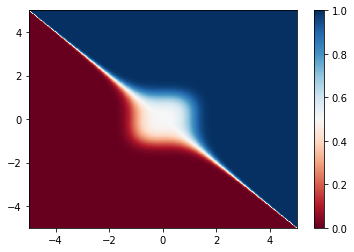

In [109]:
def plot_heatmap(x,y,probabilities, fig=None, ax=None):
    # interpretation of input: the point (x[i],y[i]) has the probability probabilities[i]
    
    if fig == None:
        fig, ax = plt.subplots()

    c = ax.pcolormesh(x, y, probabilities, cmap='RdBu', vmin=0, vmax=1)
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    fig.colorbar(c, ax=ax)

import matplotlib.pyplot as plt
import torch

# example usage
y, x = torch.meshgrid(torch.linspace(-5, 5, 500), torch.linspace(-5, 5, 500)) # produce x-y pairs
probabilities = torch.sigmoid(x**3+y**3)
plot_heatmap(x,y,probabilities)

In [110]:
def plot_losses(test_lst, outputs, legend):
    plt.figure(figsize=(16,5))
    for test,out in zip(test_lst,outputs):
        train_loss, val_loss, _ = out 
        
        plt.subplot(1,2,1)
        plt.plot(range(1,hparams['epochs']+1), train_loss, label=f'{legend}: {test}')
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(range(1,hparams['epochs']+1), val_loss, label=f'{legend}: {test}')
        plt.xlabel("epochs")
        plt.ylabel("Loss")
        plt.title("Validation Loss")
        plt.legend()

In [111]:
def plot_heatmaps_(test_lst, outputs, legend):
    # Get test samples
    y, x = torch.meshgrid(torch.linspace(5, -5, 500), torch.linspace(-5, 5, 500)) # produce x-y pairs
    grid = torch.stack([x,y],dim=2).view(-1,2)

    fig, axs = plt.subplots(1, len(outputs),  figsize=(20, 5))

    for i, out in enumerate(outputs):

        _, _, best_model = out 
        model_out, log_p_zt, l = best_model(grid)

        elbo = vae_loss(grid, model_out, log_p_zt, l, expected=False)
        elbo = (elbo - elbo.min())
        elbo = -torch.log(elbo.view(-1, 500))
        
        plot_heatmap(x.detach().numpy(), y.detach().numpy(), elbo.detach().numpy(), fig, axs[i])
        axs[i].set_title(f"Best Model with {legend}={test_lst[i]}")

## Environment 
Which python version did you use? Also, if you used any extra libraries, please list them below. \
\
`--> Python : 3.8.13` \
`--> copy`

# Experiments: Dataset A

## Different Learning Rates
Train your model with at least 3 different learning rates to help you pick a nice learning rate. Make sure that you do not change any other hyperparameters. The batch, encoding sizes and number of epochs you use is up to you. Resetting random number generators between runs will help you achieve more consistent results. You will use the test set loss to determine the best model.

In [112]:
hparams_copy = deepcopy(hparams)
lr_tests = [0.02, 0.004, 0.0008]
min_val_loss = []
outputs = []
for lr in lr_tests:
    print(50*"-")
    print(f"Training with lr: {lr}")
    hparams_copy['lr'] = lr
    out = train(model_params, hparams_copy) # out = (train_loss, val_loss, best_model)

    min_val_loss.append(min(out[1]))
    print(f"Minimum Validation Error: {min(out[1])}")

    outputs.append(out)


# Update hparams with optimal learning rate
optimum_lr = lr_tests[min_val_loss.index(min(min_val_loss))]
print(f"\nOptimum lr: {optimum_lr}")
hparams['lr'] = optimum_lr

--------------------------------------------------
Training with lr: 0.02


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 6.173438549041748
--------------------------------------------------
Training with lr: 0.004


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 7.017085552215576
--------------------------------------------------
Training with lr: 0.0008


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 10.38707160949707

Optimum lr: 0.02


### Results
Plot the training and validation losses together: one plot for the training losses and one for the validation losses. Plot the heatmap of variational lower-bound (ELBO) for the best model.

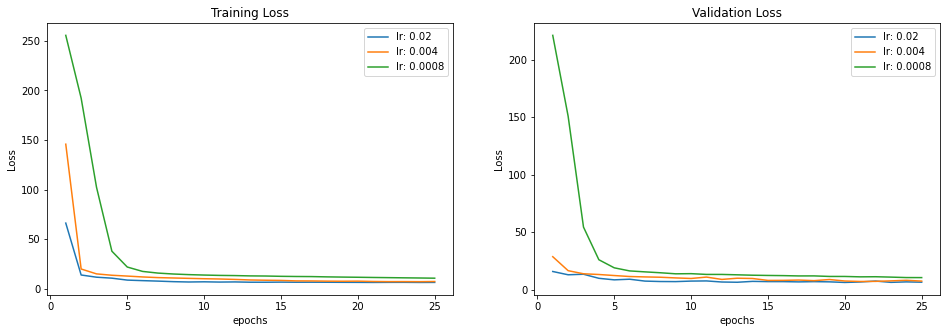

In [113]:
plot_losses(lr_tests, outputs, "lr")

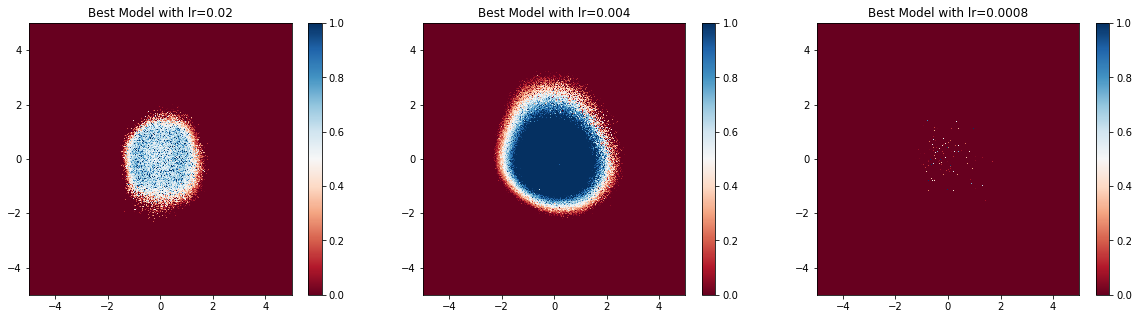

In [114]:
plot_heatmaps_(lr_tests, outputs, "lr")

## Different Encoding Sizes
At this point you more or less know a decent range to use for your learning rate. It's time to try out different encoding sizes, which is the size of the vector **z**! Train your model with 3 different encoding sizes of your choice. At each try, you can have same or different sizes at each layer.

In [115]:
model_params_copy = deepcopy(model_params)
encoding_size_tests = [8, 16, 32]

min_val_loss = []
outputs = []
for enc_size in encoding_size_tests:
    print(50*"-")
    print(f"Training with encoding size: {enc_size}")

    model_params_copy['encoder'][-1] = enc_size
    model_params_copy['decoder'][0] = enc_size

    out = train(model_params_copy, hparams) # out = (train_loss, val_loss, best_model)
    outputs.append(out)

    min_val_loss.append(min(out[1]))
    print(f"Minimum Validation Error: {min(out[1])}")

optimum_enc_size = encoding_size_tests[min_val_loss.index(min(min_val_loss))]
print(f"\nOptimum enc_size: {optimum_enc_size}")
model_params['encoder'][-1] = optimum_enc_size
model_params['decoder'][0] = optimum_enc_size

--------------------------------------------------
Training with encoding size: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 6.5676045417785645
--------------------------------------------------
Training with encoding size: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 6.529455184936523
--------------------------------------------------
Training with encoding size: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 6.8343186378479

Optimum enc_size: 16


### Results
Once again, plot the training and validation losses. Show the heatmap of best model.

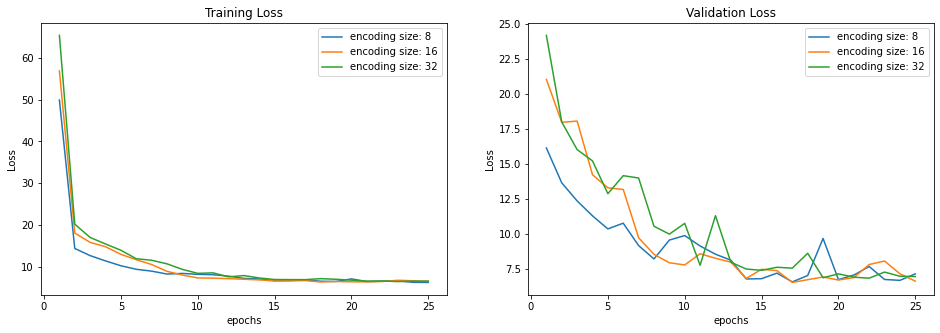

In [116]:
plot_losses(encoding_size_tests, outputs, "encoding size")

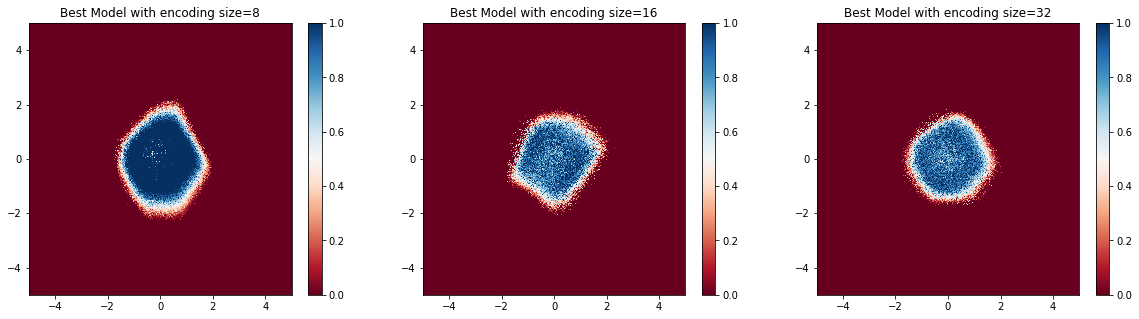

In [117]:
plot_heatmaps_(encoding_size_tests, outputs, "encoding size")

## Different Hidden Dimensions
Similar to the encoding dimension, try different hidden dimensions. Train your model with 3 different sizes for **h**.

In [118]:
model_params_copy = deepcopy(model_params)
hidden_dim_tests = [8,16, 32]

min_val_loss = []
outputs = []
for h_dim in hidden_dim_tests:
    print(50*"-")
    print(f"Training with hidden dim: {h_dim}")

    model_params_copy['context_h_dim'] = h_dim

    out = train(model_params_copy, hparams) # out = (train_loss, val_loss, best_model)
    outputs.append(out)

    min_val_loss.append(min(out[1]))
    print(f"Minimum Validation Error: {min(out[1])}")

optimum_h_dim = hidden_dim_tests[min_val_loss.index(min(min_val_loss))]
print(f"\nOptimum h_dim: {optimum_h_dim}")
model_params['context_h_dim'] = h_dim

--------------------------------------------------
Training with hidden dim: 8


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 7.009735107421875
--------------------------------------------------
Training with hidden dim: 16


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 6.358124732971191
--------------------------------------------------
Training with hidden dim: 32


  0%|          | 0/25 [00:00<?, ?it/s]

Minimum Validation Error: 7.041168689727783

Optimum h_dim: 16


### Results
Plot the training and validation losses. Again, show the heatmap of best model.

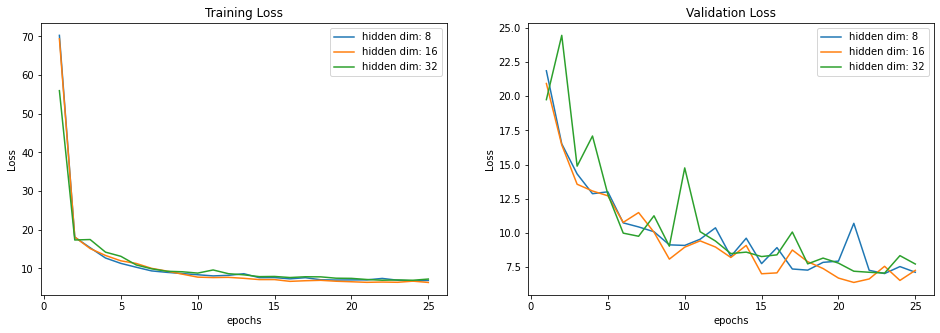

In [119]:
plot_losses(hidden_dim_tests, outputs, "hidden dim")

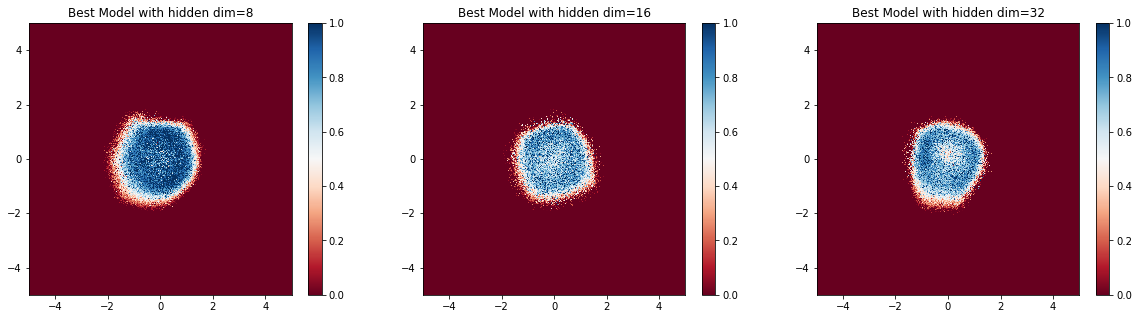

In [120]:
plot_heatmaps_(hidden_dim_tests, outputs, "hidden dim")


 # **Experiments: Dataset B**







In [121]:
hparams['train_path'] = "/Users/hcagri/Documents/METU-Master/Term II/CENG 796/Homeworks/Hw1/Data/DatasetB_train.npy"
hparams['test_path'] = "/Users/hcagri/Documents/METU-Master/Term II/CENG 796/Homeworks/Hw1/Data/DatasetB_test.npy"
hparams['epochs'] = 30

model_params = {
    "input_dim" : 2,
    "encoder" : [32, 16, 8],
    "decoder" : [8 , 4, 2],
    "context_h_dim" : 16,
    "num_flows" : 3,
    "iaf_hidden_dims" : [64]
}

In [122]:
def plot_heatmaps_(test_lst, outputs, legend):
    # Get test samples
    y, x = torch.meshgrid(torch.linspace(8, -8, 800), torch.linspace(-8, 8, 800)) # produce x-y pairs
    grid = torch.stack([x,y],dim=2).view(-1,2)

    fig, axs = plt.subplots(1, 3,  figsize=(20, 5))

    for i, out in enumerate(outputs):

        _, _, best_model = out 
        model_out, log_p_zt, l = best_model(grid)

        elbo = vae_loss(grid, model_out, log_p_zt, l, expected=False)
        elbo = (elbo - elbo.min()).log()
        elbo = -elbo.view(-1, 800)
        
        plot_heatmap(x.detach().numpy(), y.detach().numpy(), elbo.detach().numpy(), fig, axs[i])
        axs[i].set_title(f"Best Model with {legend}={test_lst[i]}")

## Different Encoding Sizes
For this dataset, we will just use the learning rate we chose for Dataset A. This time, test 3 different encoding sizes on Dataset B.

In [123]:
model_params_copy = deepcopy(model_params)
encoding_size_tests = [8, 16, 32]

min_val_loss = []
outputs = []
for enc_size in encoding_size_tests:
    print(50*"-")
    print(f"Training with encoding size: {enc_size}")

    model_params_copy['encoder'][-1] = enc_size
    model_params_copy['decoder'][0] = enc_size

    out = train(model_params_copy, hparams) # out = (train_loss, val_loss, best_model)
    outputs.append(out)

    min_val_loss.append(min(out[1]))
    print(f"Minimum Validation Error: {min(out[1])}")

optimum_enc_size = encoding_size_tests[min_val_loss.index(min(min_val_loss))]
print(f"\nOptimum enc_size: {optimum_enc_size}")
model_params['encoder'][-1] = optimum_enc_size
model_params['decoder'][0] = optimum_enc_size

--------------------------------------------------
Training with encoding size: 8


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 8.686112403869629
--------------------------------------------------
Training with encoding size: 16


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 8.959809303283691
--------------------------------------------------
Training with encoding size: 32


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 11.949645042419434

Optimum enc_size: 8


### Results
Plot the training and validation losses. Plot the probabilities calculated by the best model.

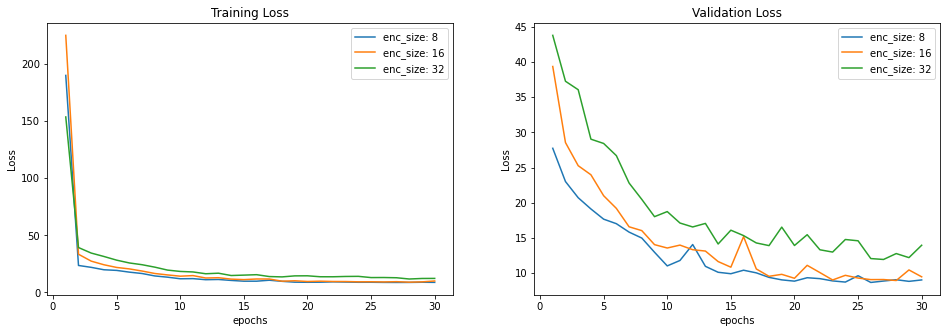

In [124]:
plot_losses(encoding_size_tests, outputs, "enc_size")

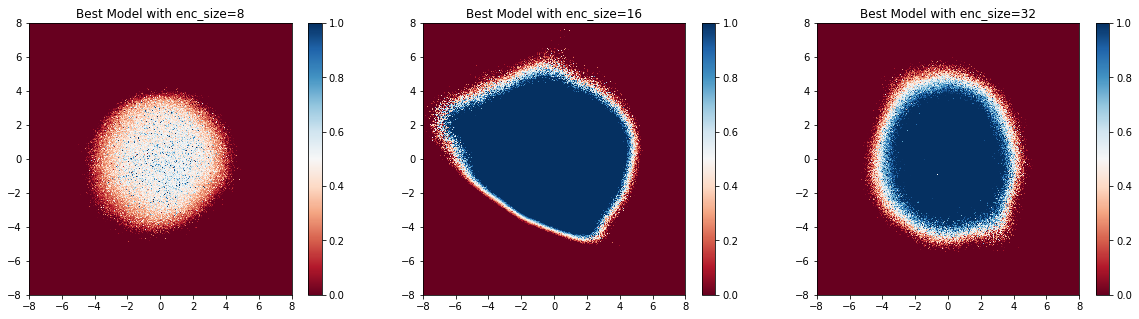

In [125]:
plot_heatmaps_(encoding_size_tests, outputs, "enc_size")

## Different Hidden Dimensions

In your final experiment, optimize the size of **h** on Dataset B by comparing 3 different hidden dimensions.

In [126]:
model_params_copy = deepcopy(model_params)
hidden_dim_tests = [8,16, 32]

min_val_loss = []
outputs = []
for h_dim in hidden_dim_tests:
    print(50*"-")
    print(f"Training with hidden dim: {h_dim}")

    model_params_copy['context_h_dim'] = h_dim

    out = train(model_params_copy, hparams) # out = (train_loss, val_loss, best_model)
    outputs.append(out)

    min_val_loss.append(min(out[1]))
    print(f"Minimum Validation Error: {min(out[1])}")

optimum_h_dim = hidden_dim_tests[min_val_loss.index(min(min_val_loss))]
print(f"\nOptimum h_dim: {optimum_h_dim}")
model_params['context_h_dim'] = h_dim

--------------------------------------------------
Training with hidden dim: 8


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 8.83041000366211
--------------------------------------------------
Training with hidden dim: 16


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 8.670931816101074
--------------------------------------------------
Training with hidden dim: 32


  0%|          | 0/30 [00:00<?, ?it/s]

Minimum Validation Error: 8.724918365478516

Optimum h_dim: 16


## Results

Plot losses and the heatmap of best model.

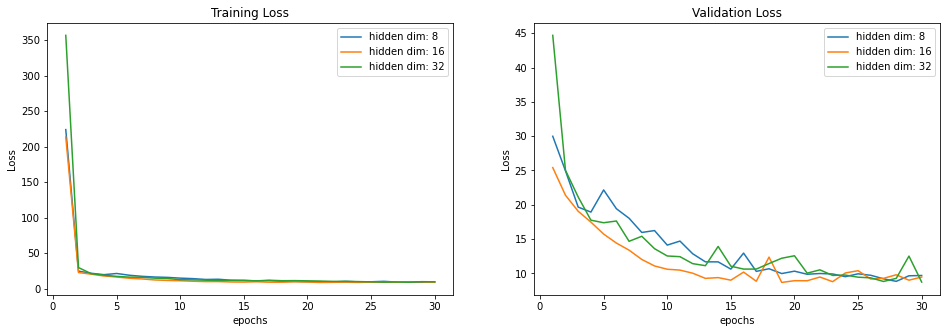

In [127]:
plot_losses(hidden_dim_tests, outputs, "hidden dim")

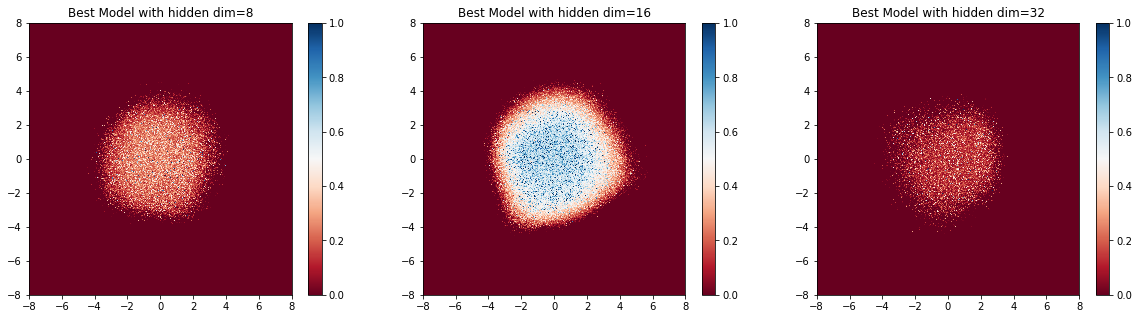

In [128]:
plot_heatmaps_(hidden_dim_tests, outputs, "hidden dim")

# Architecture
Which architecture did you use for your implementation, why, and were the results the way you expected them? Please provide references if you used well-known models.

**Answer:** \
\
`For encoder and decoder, I've used simple NN, and for Autoregressive NN block I've used MADE architecture. I chose MADE since the data that given to us was too simple, it only contains two features per sample. So, using complex architectures were redundant.`

`The results were the way I expect them. We can see from the heatmap figures that the model acually learns the probability distribution of real data. Especially in Dataset A, in some of the heatmap plots we can see that the probability distribution resembles the real data distribution. However, for Dataset B, there were 3 nested ring shape distributions in the real data however we cannot observe low probability regions between those rings in the heatmaps. When I look at the recunstructions the ELBO term is very close in both real distribution and on the points lie between the ring shaped real distributions. So even if there is a small difference between them, it is really hard to observe in the heatmap since for regions outside the real distribution ELBO is too high. This makes it hard to observe small differences in the 0-1 range after normalization.` 

# Autoregressive Neural Network
Explain why your autoregressive neural network implementation maintains the autoregressive property.

**Answer:** \
\
`I've used made architecture, which resembles the vanilla autoencoders with a small difference. The path of each input to each outputs are restricted such that, the output will be connected only the inputs who has lower index values then itself. This can be achieved by masking out weight matrices between each layers, by simply making weights 0 for not allowed connections. I created the masks random at the beginning, when model object constructed. It is also possible to change the mask layouts in every iteration or in every epoch, however it may also introduce some instabilities in training as mentioned in the MADE paper. In the MADE paper they have used predefined masks, and used those mask interchangeably. However we are experimenting different encoding and hidden dimention sizes, using predefined masks are not practical and not ideal in our case.`

# Inverse Autoregressive Transformations
What is the adventage of Inverse Autoregressive Transformations over the Autoregressive Transformations? You may refer to the [IAF paper](https://arxiv.org/abs/1606.04934).

**Answer:** \
\
`The main advantage of using Inverse Autoregressive transformation is that it has a fast generation capability utilizing parallel computations, which is also mentioned in the IAF paper in part 3. And also, we would like to use Inverse Autoregressive Transformation inside a Normalizing flow, which yields a much faster flow and is more suitable for flows from simple distribution to more complex distributions. Another advantage of Inverse Autoregressive transformation is that it allows fast likelihood evaluation for generated samples.`


